# Sweep Tutorial

---

A *sweep* design of experiment (DOE) is useful for getting a quick sense of model behavior. In this notebook we illustrate how you can use sweeps to do an initial investigation of model behavior.

In [1]:
import numpy as np
import pandas as pd
import grama as gr
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from grama.models import model_cantilever_beam

## Notebook parameters
n_monte_carlo = int(1e4)

## Model setup
model = model_cantilever_beam(w=2.80, t=3.00)

We'll demonstrate evaluating and visualizing a *sinew* sweep; there are two parameters to set:

In [2]:
## The `density` of points along a sweep
n_density = 50
## The number of sweeps
n_sweeps  = 10

The total number of points in the design is `n_density * n_sweeps * model.n_inputs`, which can quickly grow large. Consider keeping `n_sweeps` small to keep the cost of evaluation down.

In [3]:
## Perform 'sinew' sweep
np.random.seed(101) # Set for reproducibility
df_res = model >> gr.ev_sinews(n_density=n_density, n_sweeps=n_sweeps)
df_res.describe()

,H,V,E,Y,c_area,g_stress,g_displacement,sweep_ind
count,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000
mean,NaN,NaN,NaN,NaN,8.400000e+00,NaN,-inf,4.500
std,NaN,NaN,NaN,NaN,2.132161e-13,NaN,NaN,2.873
min,-inf,-inf,-inf,-inf,8.400000e+00,-inf,-inf,0.000
25%,412.187872,926.888240,2.771077e+07,3.948902e+04,8.400000e+00,1545.935704,-0.008129,2.000
50%,504.111685,1000.000000,2.907514e+07,4.169739e+04,8.400000e+00,4522.467331,0.168849,4.500
75%,558.743398,1060.976953,2.969975e+07,4.258523e+04,8.400000e+00,7450.639195,0.311274,7.000
max,inf,inf,inf,inf,8.400000e+00,inf,2.253500,9.000


### Visualizing

---

The following [scatterplot matrix](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33qb.htm) visualizes the input space. Note that the sampled points provide `n_sweeps` columns of points parallel to each input axis, with `n_density` points in each column. This provides us with the data necessary to visualize the effect of a single variable, at different values for the other inputs.

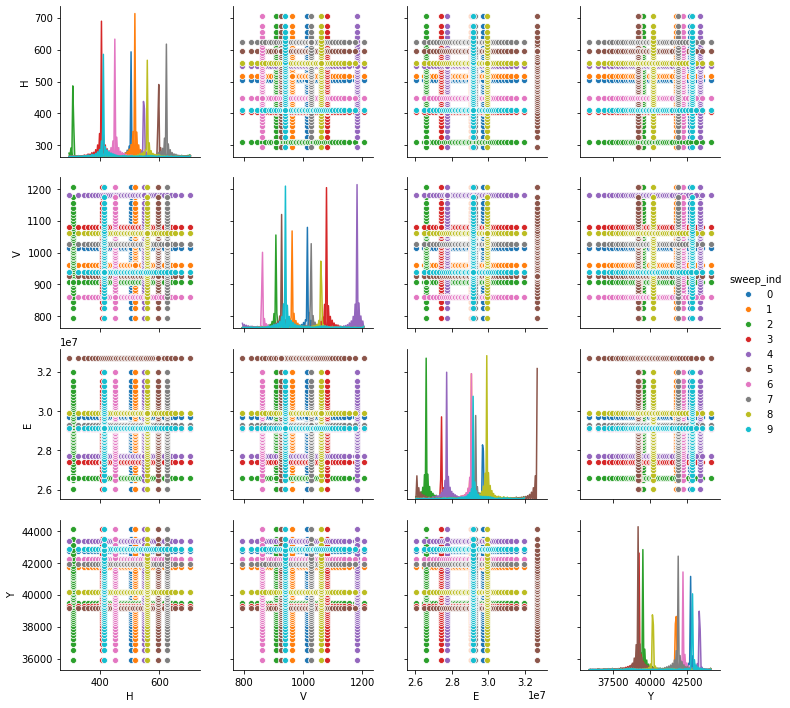

In [4]:
sns.pairplot(
    data=df_res,
    vars=model.domain.inputs,
    hue="sweep_ind"
)

We can use the `sinew` design to plot a sweep for each output across each input. This requires reshaping the data a bit with Pandas calls. The following recipe uses `pd.melt()` and a Seaborn `sns.relplot()` to construct the sweep plot.

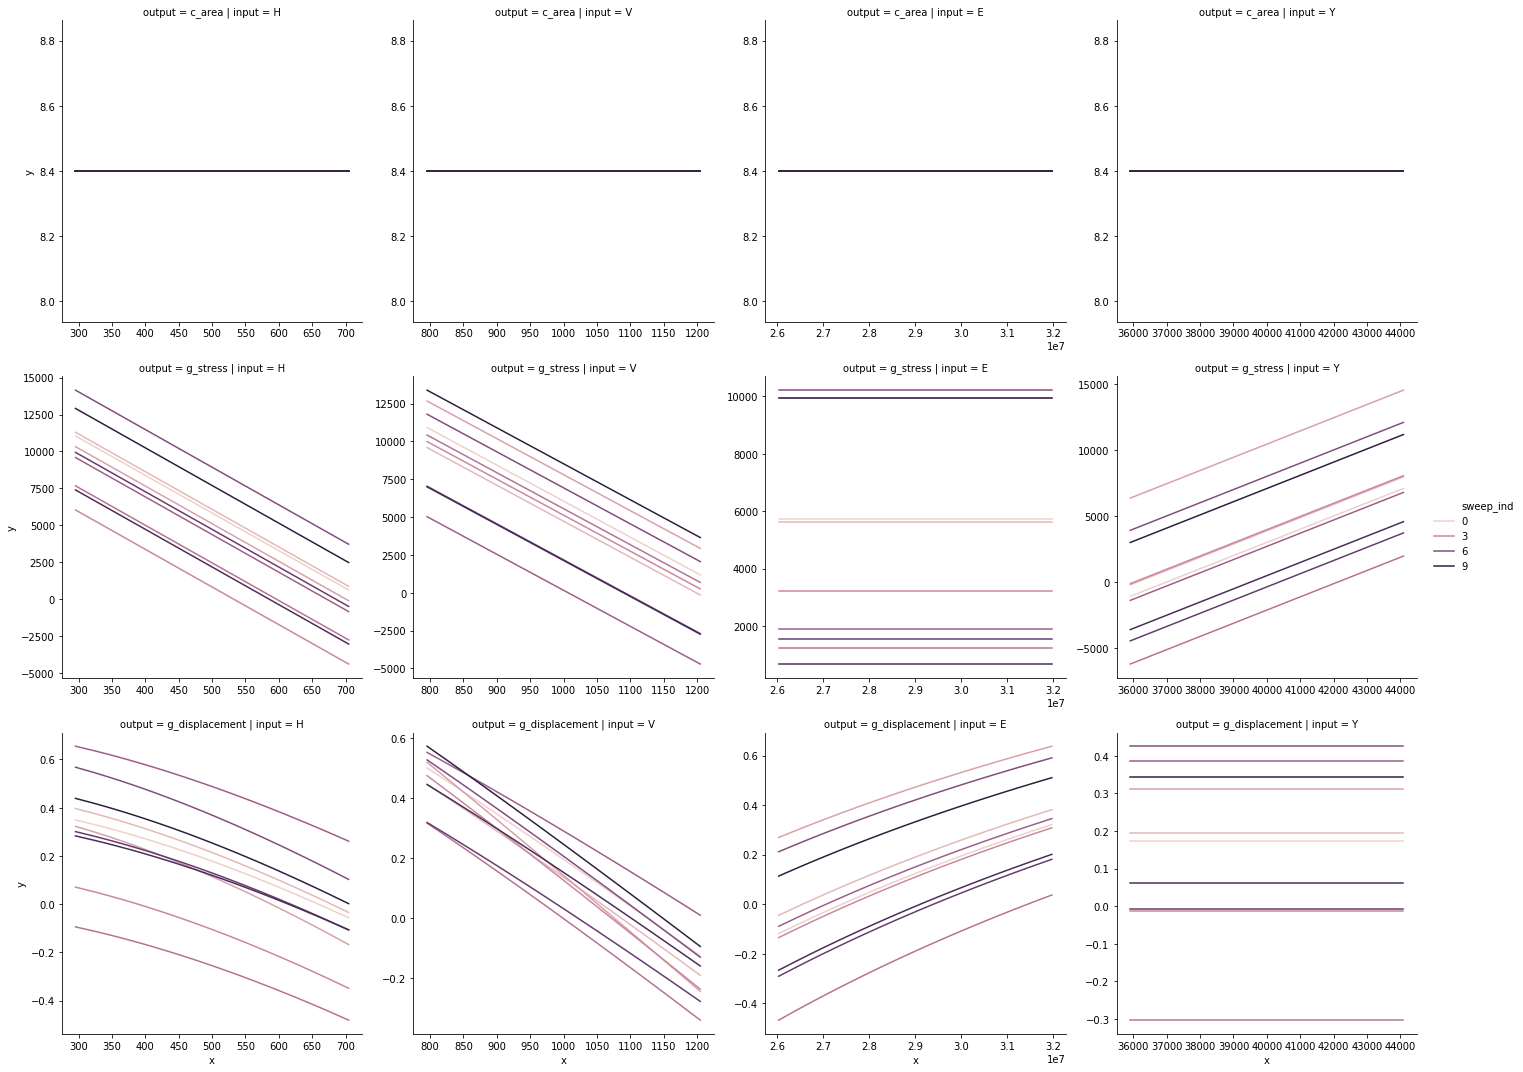

In [5]:
vars_keep = ["sweep_var", "sweep_ind"]

df_melted = pd.melt(df_res, id_vars=model.outputs+vars_keep, var_name="input", value_name="x")
df_melted = pd.melt(df_melted, id_vars=vars_keep+["x", "input"], var_name="output", value_name="y")
## Remove failed simulations
df_melted = df_melted[np.isfinite(df_melted["x"]) & np.isfinite(df_melted["y"])]
## Don't plot out-of-plane sweeps
df_melted = df_melted[df_melted["sweep_var"] == df_melted["input"]]

sns.relplot(
    data=df_melted,
    x="x",
    y="y",
    hue="sweep_ind",
    col="input",
    row="output",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False)
)

Interpreting this plot, we see that the inputs `H,V,E,Y` have no effect at all on the cost function `c_area`.

Both loads `H,V` affect the limit states for `stress` and `displacement` negatively. The elasticity `E` has zero effect on `stress`, while the yield strength `Y` has no effect on `displacement` failure. 

All of the variables effects on `stress` are essentially linear, while the inputs `H,V,E` have a nonlinear effect on `displacement`, with slopes only lightly affected by the other variables.